# TM

Temamodellering basert på clustring, klikk og grafanalyse.

Her ser vi på 
1. Bygg et korpus
1. Hvordan hente ut tematiske strukturer fra korpus
1. Hvordan evaluere temaer mot et større korpus

Om de tematisk strukturene kommer et annetsteds fra, så kan evalueringen fremdeles benyttes, og evalueres mot bokhyllas data.


### først litt kode for å komme i gang

In [1]:
import json
import pandas as pd
import dhlab.module_update as mu
mu.update('mods_meta')
import mods_meta as mm
import dhlab.nbtext as nb
import re
from IPython.display import Markdown, display
from collections import Counter
from dhlab.nbtokenizer import tokenize
import networkx as nx
import dhlab.graph_networkx_louvain as gnl
import datetime
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import json
mu.update('wordbank')

Updated file `C:\Users\yoons\Documents\GitHub\Trawling\mods_meta.py`

Updated file `C:\Users\yoons\Documents\GitHub\Trawling\wordbank.py`

In [2]:
from wordbank import word_paradigm_many, word_lemma_many, word_form_many

In [3]:
mu.css()

Set fontsizes for plots etc.

In [4]:
from nb_api_kollokasjon_konk import *

Updated file `C:\Users\yoons\Documents\GitHub\Trawling\mods_meta.py`

Updated file `C:\Users\yoons\Documents\GitHub\Trawling\collocations.py`

In [5]:
def declensions(wordbagfamily, pos = None):
    """Set pos to subst, verb or adj for limiting the inflectional forms"""
    if isinstance(pos, list):
        res = {key: list(set([w for infl_set in word_para(wordbagfamily[key]) for w in infl_set[2] if infl_set [1] in pos])) for key in wordbagfamily}
    elif isinstance( pos, str):
        res = {key: list(set([w for infl_set in word_para(wordbagfamily[key]) for w in infl_set[2] if infl_set [1] == pos])) for key in wordbagfamily}
    else:
        res = {key: list(set([w for infl_set in word_para(wordbagfamily[key]) for w in infl_set[2]])) for key in wordbagfamily}
    return res
    
    

In [6]:
def word_para(ws):
    res = word_paradigm_many(ws)
    for w in ws:
        if w not in [x[0] for x in res]:
            res.append([w, 'subs', [w]])
    return res

# Analyse

### Sammenligning 

Det kan være greit å ha en samling ord for utvalg av et sett ord fra korpuset. Om vi satser på en standard forskjellsanalyse, tar vi utgangspunkt i de 200 000 mest frekvente ordene i bokhylla. Tallet kan økes.

In [7]:
tot = nb.frame(nb.totals(200000), 'tot')

In [8]:
nb.normalize_corpus_dataframe(tot)

True

### Korpus

Bygg et korpus på en eller annen måte. Her ser vi på 10 bøker hentet fra en bestemt periode, markert med emneordet 'krig'.

In [9]:
books_ = nb.book_corpus(author = 'knaus%karl%',title='min kamp', lang= 'nob', period = (1940, 2015))

En kjapp oversikt over titler og forfatter.

In [10]:
books_

,urn,author,title,year
0,2014100308011,"Knausgård, Karl Ove",Min kamp,2011
1,2013102906036,"Knausgård, Karl Ove",Min kamp,2010
2,2012112638153,"Knausgård, Karl Ove",Min kamp,2011
3,2014013105041,"Knausgård, Karl Ove",Min kamp,2009
4,2013082806088,"Knausgård, Karl Ove",Min kamp,2010
5,2012111508072,"Knausgård, Karl Ove",Min kamp,2011
6,2013091306040,"Knausgård, Karl Ove",Min kamp,2009
7,2012111508022,"Knausgård, Karl Ove",Min kamp,2011


In [11]:
books = books_[books_.urn.isin([2014013105041, 2013102906036, 2012111508022])]

In [12]:
books

,urn,author,title,year
1,2013102906036,"Knausgård, Karl Ove",Min kamp,2010
3,2014013105041,"Knausgård, Karl Ove",Min kamp,2009
7,2012111508022,"Knausgård, Karl Ove",Min kamp,2011


For å analysere samforekomster, telles ordene. Korpuset her tilsvarer subcorpus i Tangherlini&Leonard. Desto mindre jo bedre. Ordfrekvensene normaliseres i samme rennet.

Her ser vi på trilogien Rubicon, Lass og Sangen

In [13]:
df = nb.frame(nb.aggregate_urns(list(books.urn)))
nb.normalize_corpus_dataframe(df)

True

In [36]:
nb.urn_concordance(urns=books.urn, word='hybelen')

"Min kamp, Knausgård, Karl Ove, 2010",En som våkner opp på,hybelen,og går ut . Men
"Min kamp, Knausgård, Karl Ove, 2010",Lyst til å sitte på,hybelen,"hadde jeg fortsatt ikke ,"
"Min kamp, Knausgård, Karl Ove, 2010",tiden som ventet meg på,hybelen,fram til jeg kunne gå
"Min kamp, Knausgård, Karl Ove, 2010",Hjemme på,hybelen,tok jeg ikke bare ned
"Min kamp, Knausgård, Karl Ove, 2010",ville bli med ned til,hybelen,"hans , den lå like"
"Min kamp, Knausgård, Karl Ove, 2011",Da jeg våknet opp på,hybelen,"i Elvegaten dagen etter ,"
"Min kamp, Knausgård, Karl Ove, 2011",", kjørte vi opp til",hybelen,hans . Han hadde tatt
"Min kamp, Knausgård, Karl Ove, 2011",et par scener fra selve,hybelen,", hun ligger i bare"
"Min kamp, Knausgård, Karl Ove, 2011","på , men hendelsen på",hybelen,hennes hadde vært så definitiv
"Min kamp, Knausgård, Karl Ove, 2011",komme oss inn i den,hybelen,Xiam stod avlåst i huset


In [44]:
drikke_rel = nb.frame(pd.concat([nb.urn_coll(x, urns = list(books.urn)) for x in ['drikke', 'drikker', 'drakk']], axis=1).sum(axis=1))
nb.normalize_corpus_dataframe(drikke_rel)

True

In [54]:
selection = list(nb.frame_sort(nb.frame(drikke_rel[0]/tot.tot)).head(300).index)

In [55]:
selection_forms = word_form_many(selection)

In [59]:
chosen_words = [x[0] for x in selection_forms]

Når ordene sammenlignes med det som er forventet dukker det opp en slags tematisk struktur, som vi ser i neste output. Ordene er toppordene for de som utgjør en forskjell på korpuset sammenlignet med resten av bokhylla. Men merk at enkelte bøker kan dominere her, så derfor lurt å minske antallet, eller analysere bøkene en for en. 

Vi bruker korpus-ordene for å lage en tematisk struktur. Alt vi vet foreløpig er at hver og en av dem forekommer hyppigere i korpuset enn ellers i bokverdenen. Hvordan henger de sammen?

Ordene over kan vi bruke til å konstruere en graf basert på samforekomster. Kommandoen `nb.make_network_graph` tar en liste med ord og strukturer dem basert på samforekomst. Et ord W er koblet med en bue til et annet ord V, hvis W og V opptrer i samme avsnitt. Det gir en grafstruktur som kan visualiseres og analyseres.

Her ser vi bare på ord som er mer eller mindre unike for tekstene i korpuset. Antallet ord bestemmes av parametret for `head()` i koden under. Her er den satt til 300, andre verdier gir flere ord, som vil øke størrels og antall på temaer.

Ordene som skal brukes kunne i prinsippert vært hele korpuset, men for å komme i havn før nyttårsaften, og ikke sprenge datakapasiteten gjøres et utvalg. Forskjellig sett ord kan velges og gi andre resultat.

In [60]:
Gs = [nb.make_network_graph(str(u), chosen_words) for u in books.urn]

In [61]:
G = nx.Graph()
for g in Gs:
    G.add_edges_from(g.edges(data=True))

Grafen ser sånn ut. Med fargelagte noder for clustertilhørighet.

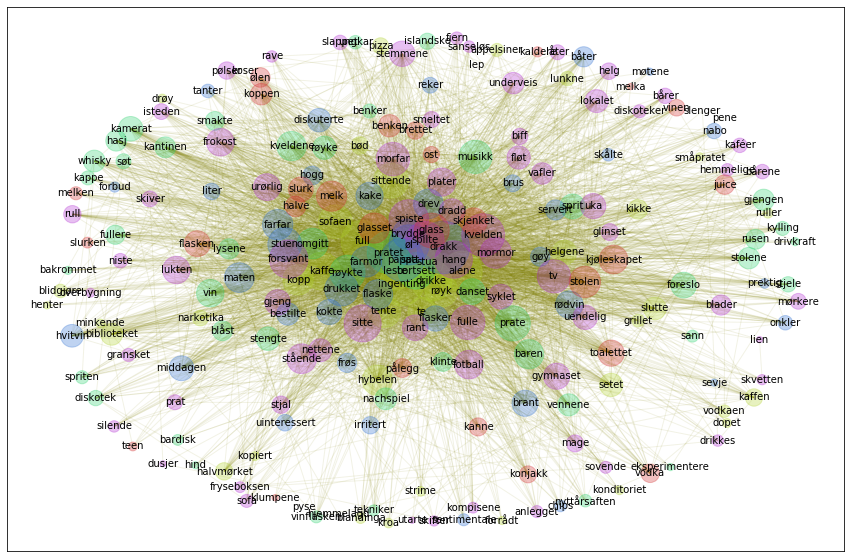

In [81]:
gnl.show_graph(G, spread = 2.8)

Nedenfor kan vi se på clustrene generert fra grafen (Louvain-metoden), som til syvende og sist er antatt å definere et aspekt ved den tematiske strukturen for korpuset. Tematikken er her basert på de viktigste ordene, beskrevet ovenfor. Andre detaljer vil komme frem ved å bruke andre ord som input, ordsekker laget ved kollokasjon for eksempel.

En mulig svakhet ved clustringsalgoritmer er at de partisjonerer ordene, sånn at ord ikke forekommer i to eller fler clustre, til forskjell fra mixtur-modeller som LDA og NMF. Klikkstrukturene er bedre i så henseende. Vi bruker dem ikke nå i første omgang men se artikkelen om forskjellen på klikk og clustring ["Graph Analysis of Word Networks”](http://ceur-ws.org/Vol-2021/paper6.pdf)..

Merkelappen på clustrene er hentet fra de mest sentrale ordene i clustret. Og hjelper litt med en begrepsmessig orden.

In [79]:
def community_dict_score(G):
    sorter = Counter(dict(nx.degree(G)))
    cd = dict()
    for c in gnl.mcommunity(G):
        l = [(x, sorter[x]) for x in c if sorter[x]>0]
        #print(l)
        l.sort(key=lambda i: i[1], reverse=True)
        #print(l)
        cd['-'.join([x[0] for x in l[:2]])] = l
    return cd

In [80]:
community_dict_score(G)

{'satt-ingenting': [('satt', 188),
  ('ingenting', 149),
  ('full', 135),
  ('drikke', 127),
  ('alene', 124),
  ('leste', 111),
  ('kaffe', 108),
  ('sittende', 92),
  ('sofaen', 86),
  ('røyk', 82),
  ('tente', 80),
  ('stua', 74),
  ('hybelen', 70),
  ('kopp', 70),
  ('te', 61),
  ('helgene', 46),
  ('setet', 41),
  ('slutte', 39),
  ('biblioteket', 36),
  ('kikke', 29),
  ('halvmørket', 23),
  ('bød', 23),
  ('kaffen', 23),
  ('pizza', 20),
  ('narkotika', 19),
  ('lunkne', 16),
  ('blidgjøre', 14),
  ('appelsiner', 13),
  ('vodkaen', 12),
  ('grillet', 12),
  ('blandinga', 9),
  ('ruller', 8),
  ('kroa', 7),
  ('strime', 7),
  ('kopiert', 6),
  ('dopet', 6),
  ('minkende', 6),
  ('drøy', 6),
  ('konditoriet', 6),
  ('småpratet', 5),
  ('forrådt', 5),
  ('henter', 4),
  ('pyse', 1)],
 'pratet-bortsett': [('pratet', 133),
  ('bortsett', 102),
  ('prate', 94),
  ('røykte', 93),
  ('musikk', 84),
  ('omgitt', 71),
  ('baren', 65),
  ('kveldene', 65),
  ('vin', 57),
  ('danset', 50),
 

In [63]:
gnl.show_communities(G)

satt-ingenting :  satt, ingenting, full, drikke, alene, leste, kaffe, sittende, sofaen, røyk, tente, stua, hybelen, kopp, te, helgene, setet, slutte, biblioteket, kikke, halvmørket, bød, kaffen, pizza, narkotika, lunkne, blidgjøre, appelsiner, vodkaen, grillet, blandinga, ruller, kroa, strime, kopiert, dopet, minkende, drøy, konditoriet, småpratet, forrådt, henter, pyse

pratet-bortsett :  pratet, bortsett, prate, røykte, musikk, omgitt, baren, kveldene, vin, danset, foreslo, sprit, kamerat, stengte, røyke, vennene, whisky, nachspiel, stolene, gjengen, hasj, kantinen, lysene, blåst, rusen, fullere, smakte, klinte, islandske, diskotek, stjele, søt, benker, kappe, kylling, ungkar, spriten, nyttårsaften, vinflasken, sann, bardisk, tekniker, bakrommet, drivkraft, hind, eksperimentere, hjemmelagd

drakk-pappa :  drakk, pappa, øl, stuen, drukket, farmor, farfar, brydde, maten, flaske, drev, rødvin, kake, brant, flasker, kokte, middagen, diskuterte, hvitvin, bestilte, servert, båter, gøy, frø

### Evaluering, tråling

Temaene generert over kan analyseres på selve korpuset, eller på et annet større korpus. Først ser vi på selve korpust

Temaene hentes ut som en familie ordklasser

In [82]:
themes = gnl.community_dict(G)

For å få med bøyningsvarianter, legger vi til infleksjonsformer for ord som har det.

In [83]:
themes_plus = declensions(themes)

### Gå gjennom bøker og tell opp temaene

In [84]:
evals = nb.wordbag_eval(themes_plus, list(books_.urn)).astype(int)

In [85]:
evals.style.background_gradient(axis = 0)

,drakk-pappa,glass-stolen,kvelden-spiste,pratet-bortsett,satt-ingenting,snitt
2012112638153,2541,1004,7310,2820,6028,3940
2014100308011,2236,1031,6205,2601,5530,3520
2013102906036,2256,1023,6216,2588,5162,3449
2013082806088,2256,976,4756,2057,3824,2773
2012111508022,2240,969,4740,2057,3804,2762
2013091306040,1892,788,4903,2073,3837,2698
2014013105041,1460,452,3570,1240,2168,1778
2012111508072,1465,450,3565,1239,2167,1777


### Evaluere mot et skjønnlitterært korpus fra samme era.

Evalueringen er uavhengig av hvordan temaordene er laget. De kan lages for hånd, genereres med LDA, eller som over, hentet fra grafer. Evalueringen teller opp ordsekkfamilien over et sett ord.

In [86]:
testkorpus = nb.book_corpus(ddk = '839%', period = (1990, 2010), limit = 20)

In [87]:
testeval = nb.wordbag_eval(themes_plus, list(testkorpus.urn)).astype(int)

Korpuset er litt for stort til visualisering, så sorterer på et trekk og tar ut de 50 beste

In [88]:
testeval.sort_values(by = 'snitt', ascending = False).head(50).style.background_gradient(axis = 0)

,drakk-pappa,glass-stolen,kvelden-spiste,pratet-bortsett,satt-ingenting,snitt
2011082308260,778,332,2711,1116,1888,1365
2009013004038,665,468,2698,842,2030,1340
2014063005120,544,137,1329,397,1038,689
2011063008189,540,220,1115,463,815,630
2011030908077,450,174,1012,287,645,513
2014100708040,319,127,748,281,609,416
2010030103013,319,42,983,216,317,375
2010092808142,463,48,684,193,417,361
2010102820022,235,52,490,232,305,262
2011040406133,71,64,186,88,111,104


In [89]:
mdata = [nb.metadata(u) for u in testeval.sort_values(by = 'snitt', ascending = False).head(50).index]

In [90]:
nb.frame(mdata)

,0
0,"[2011082308260, Kjærstad, Jan, 2006, Erobreren..."
1,"[2009013004038, Mankell, Henning, 2002, Dansel..."
2,"[2014063005120, Søbye, Espen, 2008, Ingen vei ..."
3,"[2011063008189, Årnes, Sverre, 2005, Djevelens..."
4,"[2011030908077, Mattsson, Annette, 2003, Askes..."
5,"[2014100708040, Bjørklid, Brynjulf, 2002, Enge..."
6,"[2010030103013, Nymoen, Arvid, 1998, Villmarka..."
7,"[2010092808142, Haugen, Tormod, 1990, Joakim, ..."
8,"[2010102820022, Viddal, Ingvald, 1990, Ungskog..."
9,"[2011040406133, Kaldhol, Marit, 2001, Ein augn..."


Tema som komplekse tegn. Hva er det som gir treff fra et tema/cluster i nye bøker?

In [91]:
def check_urn(urn, themes):
    return {x:nb.word_freq(urn, themes[x]) for x in themes}

In [92]:
check_urn(2011082308260, themes_plus)

{'satt-ingenting': {'aler': 1,
  'appelsiner': 1,
  'byr': 1,
  'dopet': 1,
  'drukket': 1,
  'drukne': 1,
  'drøyde': 1,
  'drøyt': 1,
  'grillet': 1,
  'halvmørke': 1,
  'helg': 1,
  'helgen': 1,
  'kikk': 1,
  'konditori': 1,
  'konditoriet': 1,
  'kopiert': 1,
  'lesende': 1,
  'leses': 1,
  'lesset': 1,
  'mink': 1,
  'ryke': 1,
  'røykende': 1,
  'sete': 1,
  'stuer': 1,
  'ter': 1,
  'bibliotek': 2,
  'drikk': 2,
  'drikker': 2,
  'henter': 2,
  'kopierer': 2,
  'rykende': 2,
  'røk': 2,
  'røyke': 2,
  'røyken': 2,
  'setet': 2,
  'settes': 2,
  'slutter': 2,
  'stuene': 2,
  'tennes': 2,
  'vodka': 2,
  'appelsinen': 3,
  'kopierte': 3,
  'rulle': 3,
  'rullende': 3,
  'røyk': 3,
  'slutte': 3,
  'tenne': 3,
  'vodkaen': 3,
  'hybelen': 4,
  'bød': 5,
  'drøye': 5,
  'koppen': 5,
  'røykte': 5,
  'kikke': 6,
  'kopiere': 6,
  'kopp': 6,
  'rullet': 6,
  'te': 6,
  'tenner': 6,
  'appelsin': 7,
  'drikke': 7,
  'halvmørket': 7,
  'kopier': 7,
  'kaffe': 8,
  'kikker': 8,
  'sof

In [93]:
values = [x for y in themes_plus.values() for x in y]

In [94]:
GL = nb.make_network_graph(2011082308260, values)

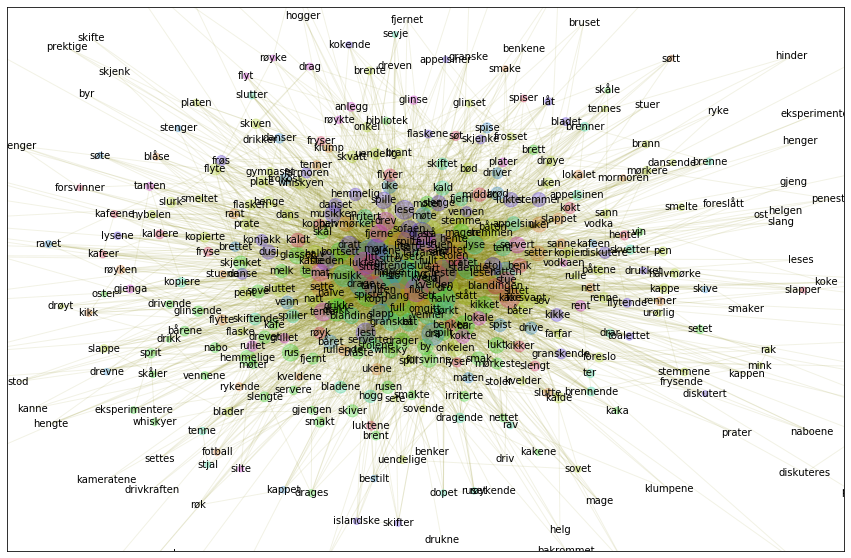

In [95]:
gnl.show_graph(GL)

In [96]:
gnl.show_communities(GL)

sto-sitt :  sto, sitt, sett, satte, alene, stå, dro, slutt, sant, forsvant, hentet, sittet, halve, stått, stemme, stemmen, båten, halv, onkelen, natt, sluttet, båter, pent, whiskyen, sov, spill, uendelig, skvatt, flyte, henge, dans, kopier, plate, bød, prate, kalde, uken, flasken, drøye, renne, kappe, kopierte, brant, båtene, slurk, skiven, onkel, foreslo, farfar, flaske, pen, hybelen, halvmørke, sann, blader, mørkere, gymnaset, kvelder, brente, slappe, frosset, stemmene, rulle, glinset, uendelige, sovende, brann, smelte, smeltet, urørlig, platen, tennes, dansende, sovet, mink, drøyt, rak, sete, mage, fjernet, naboene, dreven, stoler, foreslått, peneste, koke, blåsten, helg, eksperimenterte, morfar, morfaren, fjernere, byr, skjenk, bakrommet, fjernes, drikker, diskuteres, drivkraften, kameratene, hogd, biff, prat, drukne, irriterende, frø, kopierer

kvelden-full :  kvelden, full, kveld, spiste, drakk, bar, bortsett, kikket, drager, rus, magen, glasset, serverte, forsvinne, by, whisky, 